In [72]:
import numpy as np
import os
import pandas as pd
from sklearn.metrics import accuracy_score

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import models.simpleConv as simpleConv
from imgaug import augmenters as iaa

import h5py


dataPath = 'RealImageNet/ImageNetSubsample/Data/CLS-LOC'
trainPath = os.path.join(dataPath, 'train')
# fiveTrain = os.path.join(dataPath, 'fiveTrain')
# testPath = os.path.join(dataPath, 'test')
# validationPath = os.path.join(dataPath, 'val')
outputModelPath = os.path.join('output','saved-models')
outputFigPath = os.path.join('output', 'figs')

saveModel = True
loadModel = False
trainModel = True
includeAugmented = False
onlyAugmented = False


loadModelPath = os.path.join(outputModelPath, 'model1.h5')
if(loadModel):
    if not os.path.exists(loadModelPath):
        print("No such model file: " + loadModelPath)

baseModelName = "model-{0}-{1}-{2}"

def make_output_dirs(dirs):
    for d in dirs:
        if not os.path.isdir(d):
            os.makedirs(d)
make_output_dirs([outputModelPath, outputFigPath])

# trainPath = fiveTrain

img_width, img_height = 224, 224

lines = [line.rstrip('\n').split() for line in open('RealImageNet/LOC_synset_mapping.txt')]
wnids_to_words = {line[0]:' '.join(line[1:]) for line in lines }
trainingFolders = [x for x in os.listdir(trainPath) if x.startswith('n')]
trainingFolders = trainingFolders[0:5]

In [53]:
def parseData(saveFile = None):
    x_train = []
    x_train_aug = []
    y_train_aug = []
    y_train = []
    x_val = []
    y_val = []
    
    filePaths = []


    train_bboxes = {} #{image_name: list(bboxes)}
#     for id in trainingFolders:
    boxesPath = os.path.join("RealImageNet", "LOC_train_solution.csv")
    lines = [line.rstrip('\n').split(',') for line in open(boxesPath)][1:]
    for line in lines:
        imageId = line[0]
        predictionString = line[1]
        split = predictionString.split()
        train_bboxes[imageId] = []
        for i in range(0, len(split), 5):
            box = split[i:i+5]
            train_bboxes[imageId].append(box)

    for imageName in train_bboxes.keys():
        imageLabel = imageName.split('_')[0]
        imagePath = os.path.join(trainPath, imageLabel, imageName + ".JPEG") #folder name

        if os.path.exists(imagePath) and imageLabel in trainingFolders:
            img = image.load_img(imagePath, target_size=(224, 224)) #pil format
            x = image.img_to_array(img)/255.

            for box in train_bboxes[imageName]:
                x_train.append(x)
                idk = [imageLabel[1:]]
                y_train.append(idk)
#                 filePaths.append(imageName)

                
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)
    
    for k in range(0, len(x_train)):
        x = x_train[k]
        y = y_train[k]
        augers = [iaa.GaussianBlur(3.0), iaa.Fliplr(1.0), iaa.Invert(0.6, per_channel=True, max_value=1, min_value=0)]

        for auger in augers:
            aug = auger.augment_image(x)
            x_train_aug.append(aug)
            y_train_aug.append(y)
    
    x_train = np.array(x_train)
    y_train = np.array(y_train, dtype = 'uint')
    
    x_train_aug = np.array(x_train_aug)
    y_train_aug = np.array(y_train_aug, dtype='uint')
    
    x_val = np.array(x_val)
    y_val = np.array(y_val, dtype='uint')
    
    filePaths = np.array(filePaths)
    
    if saveFile: # if not None
        output = h5py.File(saveFile, 'w') 
        output.create_dataset('x_train', data = x_train) 
        output.create_dataset('y_train', data = y_train) 
        output.create_dataset('x_val', data = x_val)
        output.create_dataset('y_val', data = y_val)
        output.create_dataset('x_train_aug', data = x_train_aug) 
        output.create_dataset('y_train_aug', data = y_train_aug) 
#         output.create_dataset('filePaths', data = filePaths) 
        output.close()
    
    return x_train, x_train_aug, y_train, y_train_aug, x_val, y_val, filePaths

In [89]:
y_train

array([[0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1]])

In [73]:
# from keras.preprocessing import image
# get training data

parse = False

if parse:
    x_train, x_train_aug, y_train, y_train_aug, x_val, y_val, filePaths = parseData('savedParsingAll.h5')
else:
    input_data = h5py.File('savedParsingAll.h5', 'r') 
    x_train = input_data['x_train'][:] 
    y_train = input_data['y_train'][:] 
    x_train_aug = input_data['x_train_aug'][:] 
    y_train_aug = input_data['y_train_aug'][:]
    x_val = input_data['x_val'][:]
    y_val = input_data['y_val'][:]
#     filePaths = input_data['filePaths'][:] 
    input_data.close()


if includeAugmented:
    if onlyAugmented:
        x_train = x_train_aug
        y_train = y_train_aug
    else:
        
        x_train = np.concatenate([x_train, x_train_aug])
        y_train = np.concatenate([y_train, y_train_aug])
        
label_encoder = LabelBinarizer()
# y_train = label_encoder.fit_transform(y_train)
# y_val = label_encoder.fit_transform(y_val)
# y_train_aug = label_encoder.fit_transform(y_train_aug)

y_all = np.concatenate([y_train, y_val]) 
y_all = label_encoder.fit_transform(y_all) 
y_train = y_all[:len(y_train)] 
y_val = y_all[len(y_train):]


In [58]:
if includeAugmented:
#     if onlyAugmented:
#         x_train = np.array([])
#         y_train = np.array([])
 
    if onlyAugmented:
        x_train = x_train_aug
        y_train = y_train_aug
    else:
        x_train = np.concatenate([x_train, x_train_aug])
        y_train = np.concatenate([y_train, y_train_aug])

label_encoder = LabelBinarizer()
# y_train = label_encoder.fit_transform(y_train)
# y_val = label_encoder.fit_transform(y_val)
# y_train_aug = label_encoder.fit_transform(y_train_aug)

y_all = np.concatenate([y_train, y_val]) 
y_all = label_encoder.fit_transform(y_all) 
y_train = y_all[:len(y_train)] 
y_val = y_all[len(y_train):]
    
    

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [69]:
y_train.shape

(9432, 5)

In [66]:
y_train_aug.shape

(7074, 1)

In [60]:
y_val.shape

(590, 5)

In [63]:
x_train_aug.shape

(7074, 224, 224, 3)

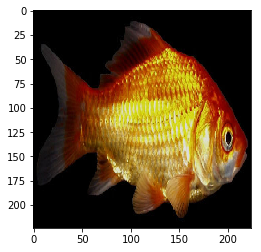

In [80]:
x = x_train[2]
plt.imshow(x)

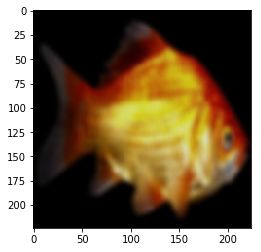

In [81]:
x = x_train[2]
var =iaa.GaussianBlur(3.0).augment_image(x)
plt.imshow(var)

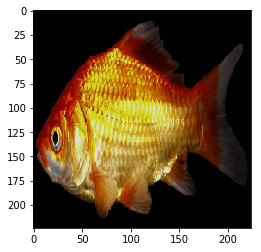

In [82]:
x = x_train[2]
var = iaa.Fliplr(1.0).augment_image(x)
plt.imshow(var)

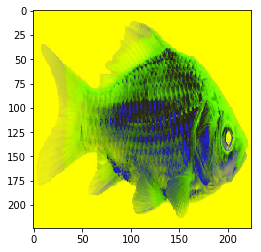

In [83]:
x = x_train[2]
var = iaa.Invert(0.6, per_channel=True, max_value=1, min_value=0).augment_image(x)
plt.imshow(var)

In [84]:
# x_train = x_train_aug
# y_train = y_train_aug

#Generate unique model name so as not to overwrite previously saved model on disk. 
count = 1 
outputName = "" 
epochs = 10

while True:
    k = ''
    if includeAugmented:
        k = 'with-aug'
    if onlyAugmented:
        k = 'aug-only'
    s = baseModelName.format(epochs, count, k)    
    if not s+".h5" in os.listdir(outputModelPath):         
        outputName = s         
        break     
    else:         
        count+=1 
print(outputName)

# callbacks =[EarlyStopping(monitor='val_loss', patience=5)]
callbacks = []

if loadModel:
    model = load_model(loadModelPath)
else:
    model = simpleConv.build_model(img_width, img_height, 3)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
if trainModel:
    results = model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs=epochs, verbose=1, callbacks = callbacks)

if saveModel:
    model.save(os.path.join(outputModelPath, outputName + ".h5"))

model-10-1-
Train on 2358 samples, validate on 590 samples
Epoch 1/10
2358/2358 [==============================] - 8s 3ms/step - loss: 1.0654 - acc: 0.5140 - val_loss: 0.9564 - val_acc: 0.5186
Epoch 2/10
2358/2358 [==============================] - 5s 2ms/step - loss: 0.8508 - acc: 0.6145 - val_loss: 0.8159 - val_acc: 0.6169
Epoch 3/10
2358/2358 [==============================] - 5s 2ms/step - loss: 0.7739 - acc: 0.6472 - val_loss: 0.7407 - val_acc: 0.6576
Epoch 4/10
2358/2358 [==============================] - 5s 2ms/step - loss: 0.6997 - acc: 0.6883 - val_loss: 0.6948 - val_acc: 0.6864
Epoch 5/10
2358/2358 [==============================] - 5s 2ms/step - loss: 0.6445 - acc: 0.7142 - val_loss: 0.7383 - val_acc: 0.6831
Epoch 6/10
2358/2358 [==============================] - 5s 2ms/step - loss: 0.6192 - acc: 0.7324 - val_loss: 0.6931 - val_acc: 0.7119
Epoch 7/10
2358/2358 [==============================] - 5s 2ms/step - loss: 0.5288 - acc: 0.7651 - val_loss: 0.7446 - val_acc: 0.6932
Epo

In [13]:
x_train.shape

(2358, 224, 224, 3)

In [14]:
y_train.shape

(2358, 5)

In [ ]:
y_train


In [15]:
y_val.shape

(590, 1)

In [16]:
x_val.shape

(590, 224, 224, 3)

# 4. Testing & Post-Processing (Metrics, Graphs, etc.)

## Plot Training Results

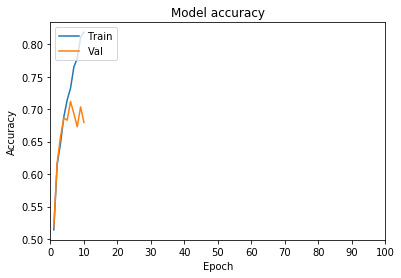

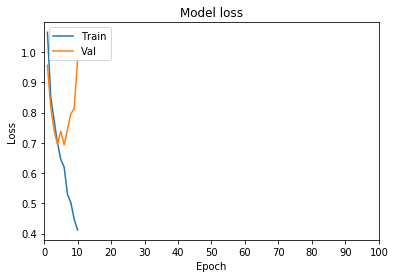

In [85]:
# Plot training & validation accuracy values
from matplotlib.ticker import FormatStrFormatter

x = np.arange(epochs)+1
plt.plot(x, results.history['acc'])
plt.plot(x, results.history['val_acc'])
# plt.xticks(x)
# plt.xticks([10*i for i in range(0, 11)])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
# plt.ylim(0.5, 1.0)
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig(os.path.join('output', 'figs', outputName+'-accuracy.png'))
plt.show()

# Plot training & validation loss values
plt.plot(x, results.history['loss'])
plt.plot(x, results.history['val_loss'])
# plt.xticks(x)
# plt.xticks([10*i for i in range(0, 11)])
plt.title('Model loss')
plt.ylabel('Loss')
# plt.ylim(0, 0.7)
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig(os.path.join('output', 'figs', outputName+'-loss.png'))
plt.show()

In [43]:
predictedModelVal = model.predict(x_val)
predictedModelTrain = model.predict(x_train)



predLabelVal = [wnids_to_words['n0' + str(int(x))] for x in label_encoder.inverse_transform(predictedVal)]

trueLabelVal = [wnids_to_words['n0' + str(int(x))] for x in label_encoder.inverse_transform(y_val)]

predLabelTrain = [wnids_to_words['n0' + str(int(x))] for x in label_encoder.inverse_transform(predictedModelTrain)]

trueLabelTrain = [wnids_to_words['n0' + str(int(x))] for x in label_encoder.inverse_transform(y_train)]



import pandas as pd
from sklearn.metrics import accuracy_score

dataframeVal = pd.DataFrame({'pred': predLabel1, 'true': trueLabel1})

dataframeTrain = pd.DataFrame({'pred': predLabel2, 'true': trueLabel2})

print("Validation Accuracy = {0}".format(accuracy_score(dataframeVal.pred, dataframeVal.true)))
print("Training Accuracy = {0}".format(accuracy_score(dataframeTrain.pred, dataframeTrain.true)))


Validation Accuracy = 0.7218767665347654
Training Accuracy = 0.7477031802120141


In [10]:
label_encoder.inverse_transform(y_train)

array([1443537, 1440764, 1443537, ..., 1443537, 1491361, 1443537],
      dtype=uint32)

In [9]:
y_train

array([[0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0]])

In [7]:
y_val

array([[0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0]])

In [8]:
label_encoder.inverse_transform(y_val)

array([1494475, 1443537, 1440764, 1443537, 1443537, 1484850, 1443537,
       1443537, 1484850, 1494475, 1443537, 1484850, 1491361, 1491361,
       1440764, 1440764, 1484850, 1443537, 1443537, 1440764, 1440764,
       1484850, 1494475, 1440764, 1491361, 1484850, 1484850, 1484850,
       1443537, 1491361, 1443537, 1494475, 1443537, 1443537, 1494475,
       1491361, 1443537, 1484850, 1494475, 1491361, 1443537, 1491361,
       1484850, 1494475, 1443537, 1443537, 1443537, 1484850, 1443537,
       1491361, 1443537, 1491361, 1440764, 1494475, 1440764, 1440764,
       1484850, 1484850, 1491361, 1443537, 1443537, 1443537, 1494475,
       1491361, 1440764, 1484850, 1494475, 1494475, 1443537, 1443537,
       1491361, 1440764, 1491361, 1494475, 1491361, 1440764, 1491361,
       1491361, 1494475, 1484850, 1443537, 1443537, 1494475, 1443537,
       1440764, 1443537, 1494475, 1443537, 1484850, 1443537, 1443537,
       1494475, 1494475, 1484850, 1440764, 1440764, 1443537, 1484850,
       1484850, 1443

In [111]:
dataframe[dataframe.pred != dataframe.true]

,pred,true
1,"great white shark, white shark, man-eater, man...","hammerhead, hammerhead shark"
6,"hammerhead, hammerhead shark","great white shark, white shark, man-eater, man..."
8,"tiger shark, Galeocerdo cuvieri","great white shark, white shark, man-eater, man..."
9,"hammerhead, hammerhead shark","tiger shark, Galeocerdo cuvieri"
10,"hammerhead, hammerhead shark","great white shark, white shark, man-eater, man..."
11,"hammerhead, hammerhead shark","great white shark, white shark, man-eater, man..."
14,"hammerhead, hammerhead shark","tiger shark, Galeocerdo cuvieri"
17,"tench, Tinca tinca","goldfish, Carassius auratus"
20,"hammerhead, hammerhead shark","tiger shark, Galeocerdo cuvieri"
22,"hammerhead, hammerhead shark","tiger shark, Galeocerdo cuvieri"


In [109]:
label_encoder.inverse_transform(predictedModel).info

AttributeError: 'numpy.ndarray' object has no attribute 'info'

In [100]:
trueLabel2

[1491361,
 1443537,
 1484850,
 1494475,
 1484850,
 1443537,
 1440764,
 1491361,
 1494475,
 1491361,
 1440764,
 1491361,
 1491361,
 1440764,
 1494475,
 1491361,
 1440764,
 1443537,
 1484850,
 1494475,
 1491361,
 1440764,
 1443537,
 1484850,
 1440764,
 1443537,
 1491361,
 1443537,
 1484850,
 1443537,
 1491361,
 1440764,
 1491361,
 1443537,
 1443537,
 1484850,
 1484850,
 1443537,
 1443537,
 1491361,
 1443537,
 1443537,
 1443537,
 1443537,
 1443537,
 1440764,
 1494475,
 1491361,
 1440764,
 1443537,
 1443537,
 1443537,
 1494475,
 1491361,
 1443537,
 1484850,
 1440764,
 1491361,
 1494475,
 1440764,
 1443537,
 1494475,
 1443537,
 1491361,
 1494475,
 1440764,
 1440764,
 1484850,
 1443537,
 1494475,
 1440764,
 1491361,
 1484850,
 1491361,
 1440764,
 1440764,
 1491361,
 1440764,
 1443537,
 1494475,
 1440764,
 1443537,
 1491361,
 1491361,
 1443537,
 1440764,
 1491361,
 1491361,
 1440764,
 1484850,
 1491361,
 1484850,
 1491361,
 1484850,
 1443537,
 1491361,
 1484850,
 1484850,
 1491361,
 1491361,


In [46]:
predictedModel2.shape

(2358, 5)

In [39]:
dataframe2

,pred,true
0,1440764,1440764
1,1440764,1440764
2,1440764,1440764
3,1440764,1440764
4,1440764,1440764
5,1440764,1440764
6,1440764,1440764
7,1440764,1440764
8,1440764,1440764
9,1440764,1440764


In [22]:
predLabel1

['great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tench, Tinca tinca',
 'tiger shark, Galeocerdo cuvieri',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri',
 'tiger shark, Galeocerdo cuvieri',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'goldfish, Carassius auratus',
 'goldfish, Carassius auratus',
 'tiger shark, Galeocerdo cuvieri',
 'great white shark, white shark, man-eater, man-eati

In [23]:
predLabel2

['tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'goldfish, Carassius auratus',
 '

In [24]:
trueLabel2

['tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Tinca tinca',
 'tench, Ti

In [42]:
trueLabel1

AttributeError: 'list' object has no attribute 'shape'